In [77]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import mapclassify as mc
import geoplot as gplt
import geoplot.crs as gcrs

import libpysal.weights as sw #spatial weights
from pysal.explore.esda import Moran, Moran_Local #global & local Moran's I
from splot.esda import lisa_cluster
from sklearn.cluster import KMeans, AgglomerativeClustering

In [66]:
df = gpd.read_file("data/shp/MD_tract.shp").merge(gpd.read_file("data/shp/MD_df.shp").drop(columns="geometry"), on="GEOID")
df = df.dropna().to_crs("EPSG:4326")

In [52]:
data = df["case0630"].astype(int).to_list() + df["case0831"].astype(int).to_list()

scheme = mc.NaturalBreaks(data, k=5)
scheme

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  26.00] |  1230
( 26.00,  53.00] |   976
( 53.00,  93.00] |   420
( 93.00, 163.00] |   107
(163.00, 325.00] |    35

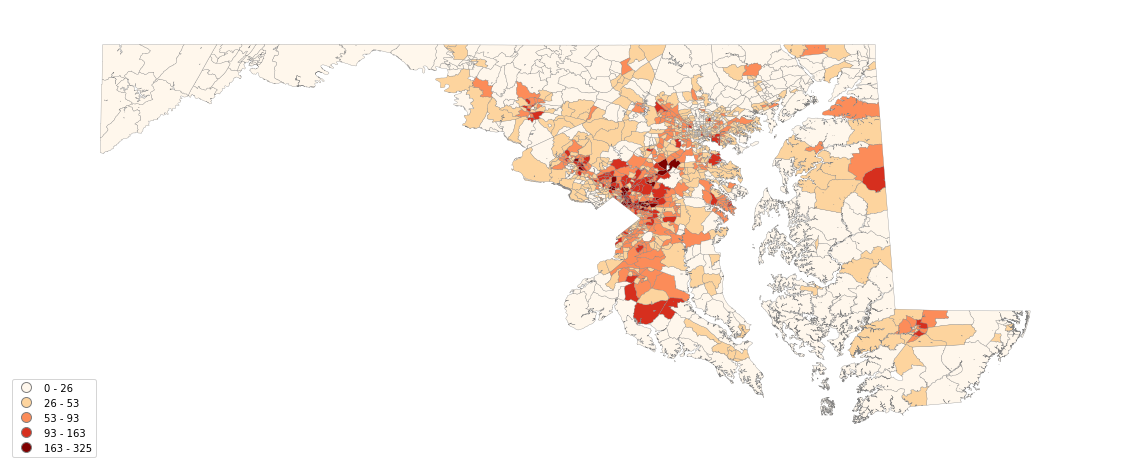

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))

gplt.choropleth(
    df,
    hue="case0630", scheme=scheme,
    cmap="OrRd", edgecolor="grey", linewidth=0.3,
    legend=True, legend_kwargs={"loc": "lower left"},
    ax=ax)

plt.show()
fig.savefig("figs/COVID-19/cases_0315_0630.png", dpi=220)

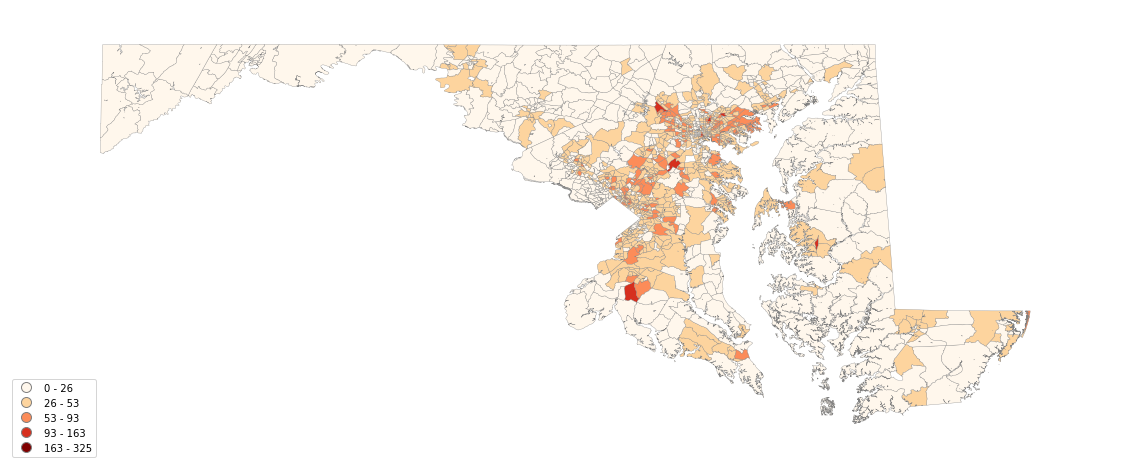

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))

gplt.choropleth(
    df,
    hue="case0831", scheme=scheme,
    cmap="OrRd", edgecolor="grey", linewidth=0.3,
    legend=True, legend_kwargs={"loc": "lower left"},
    ax=ax)

plt.show()
fig.savefig("figs/COVID-19/cases_0701_0831.png", dpi=220)

In [67]:
df.columns

Index(['GEOID', 'geometry', 'TotalPop', 'White', 'Black', 'Native', 'Asian',
       'Other', 'PopDen', 'Age0-19', 'Age20-39', 'Age40-59', 'Age60-79',
       'Age80+', 'Bachelor+', 'BelowPov', 'MHI', 'UnempRt', 'Uninsured',
       'case0630', 'case0831'],
      dtype='object')

White


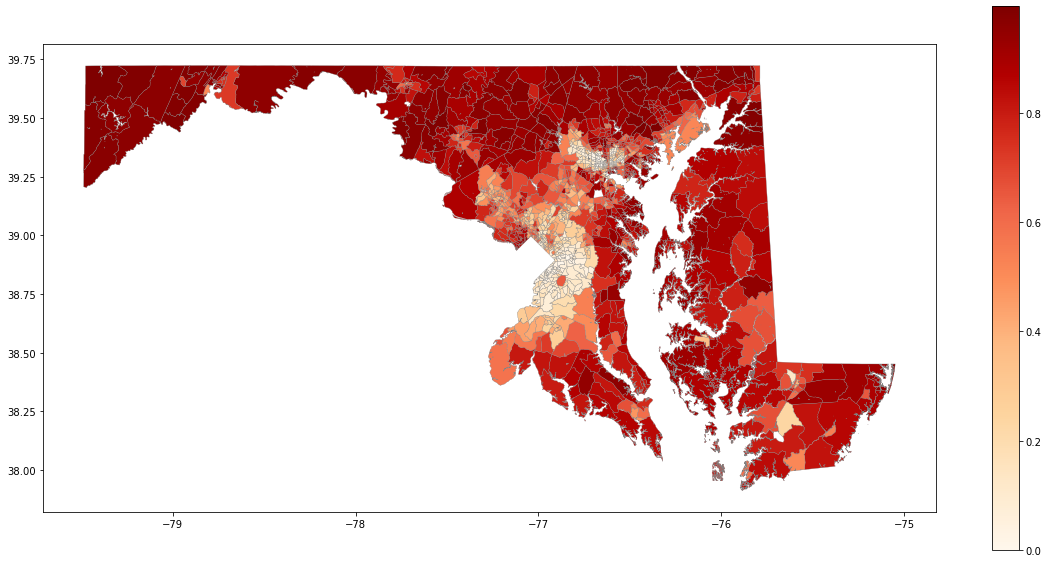

Black


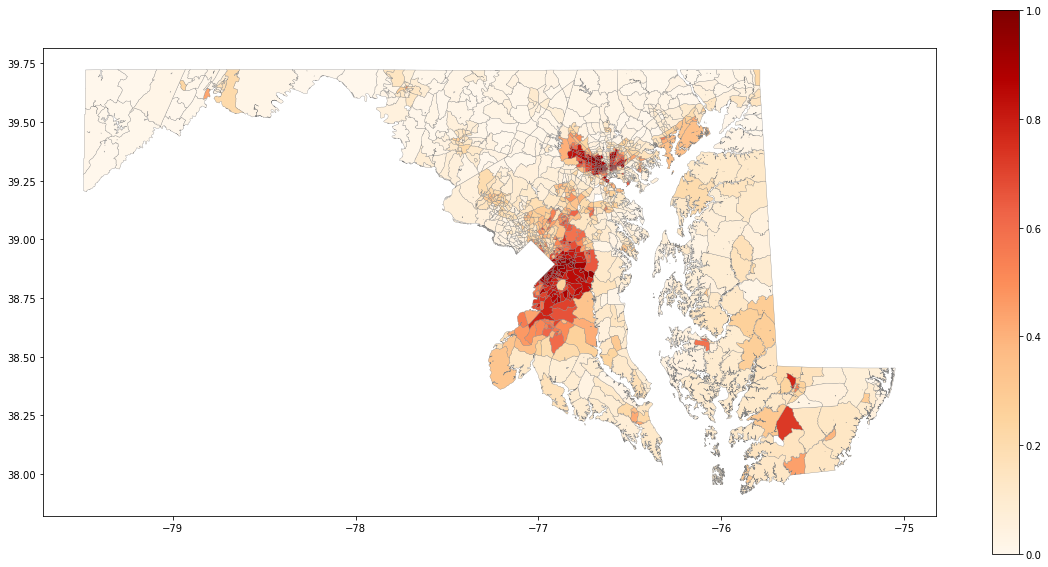

Native


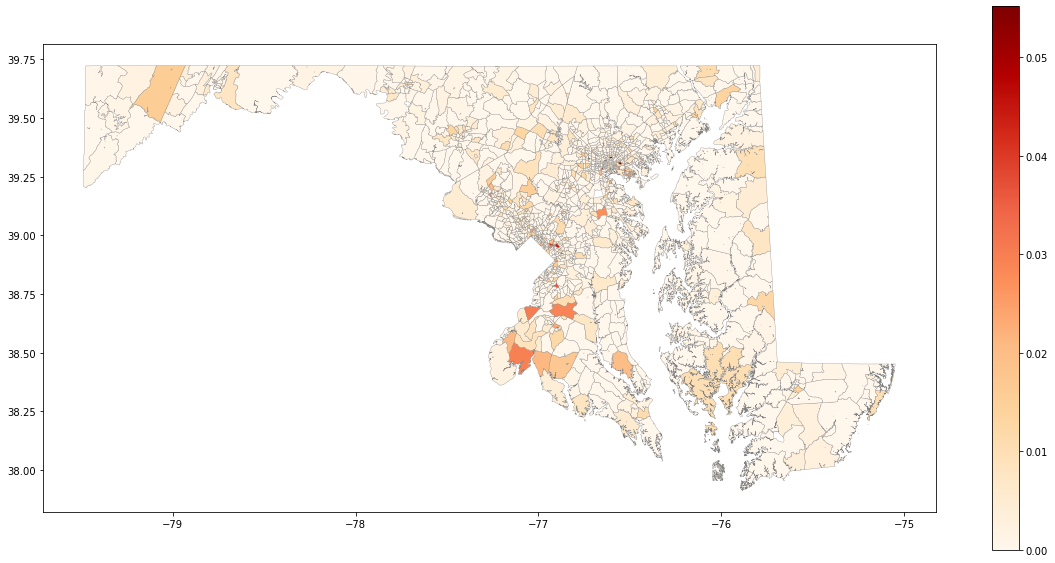

Asian


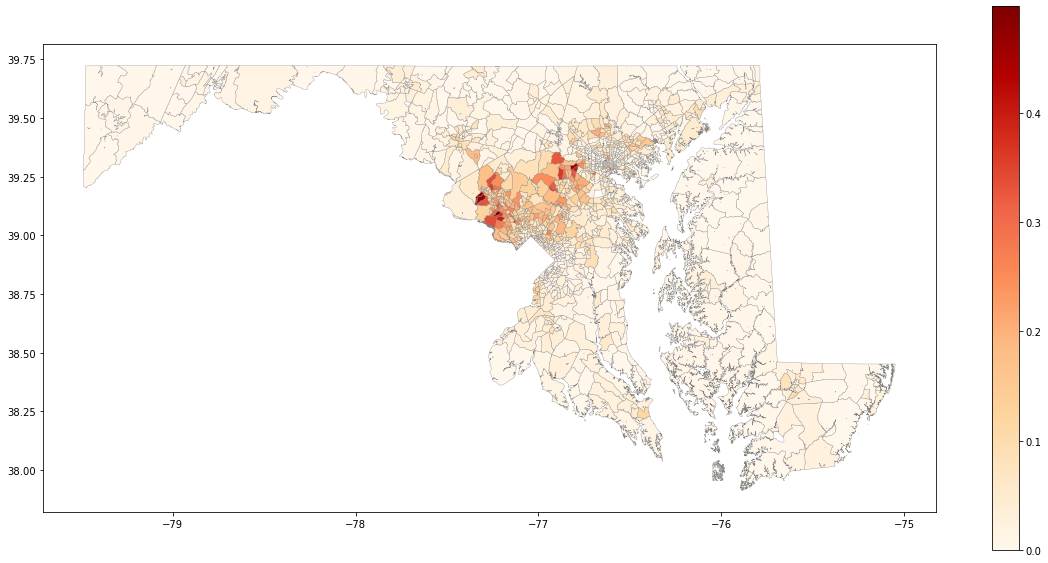

Other


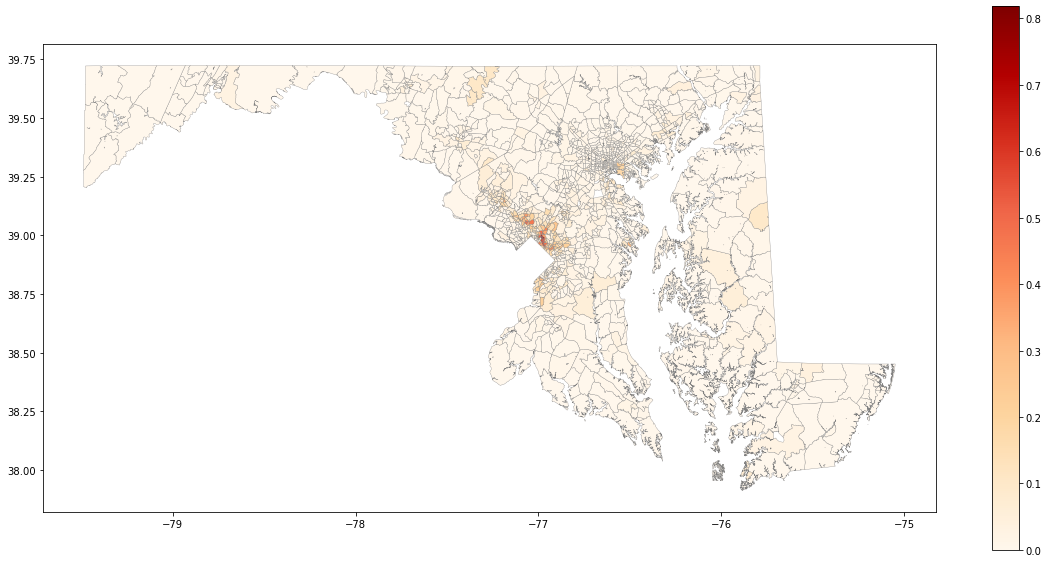

PopDen


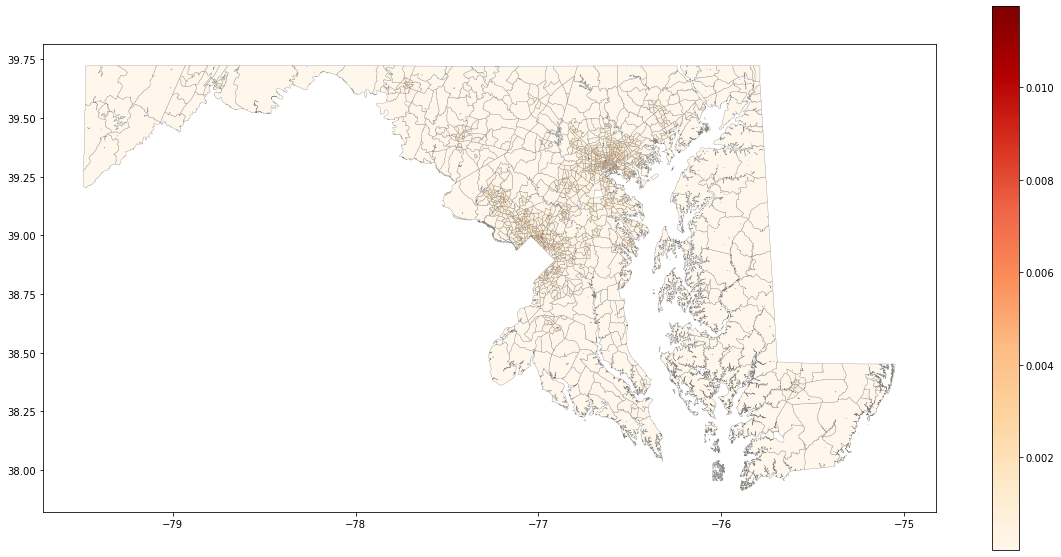

Age0-19


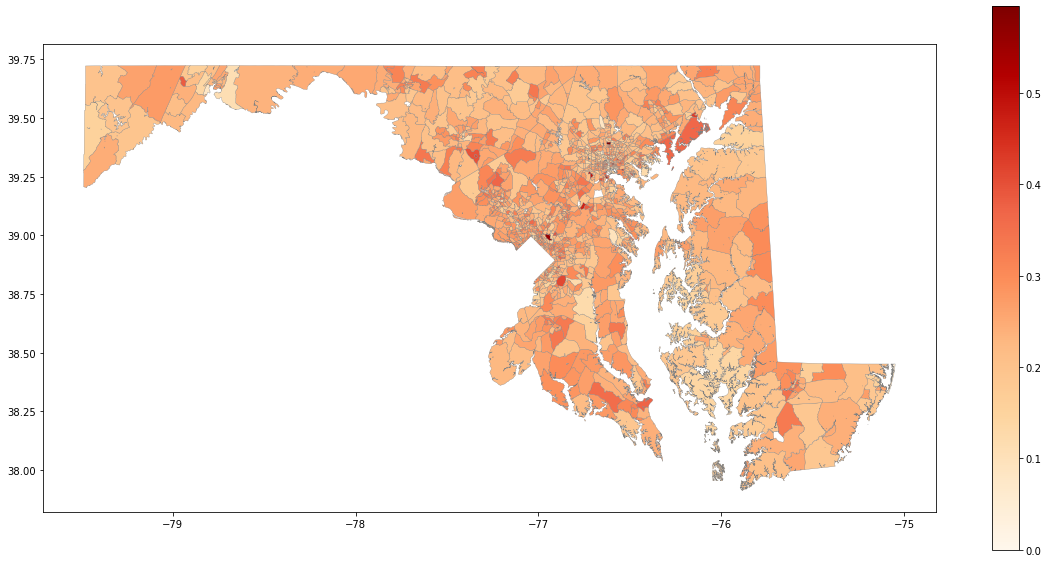

Age20-39


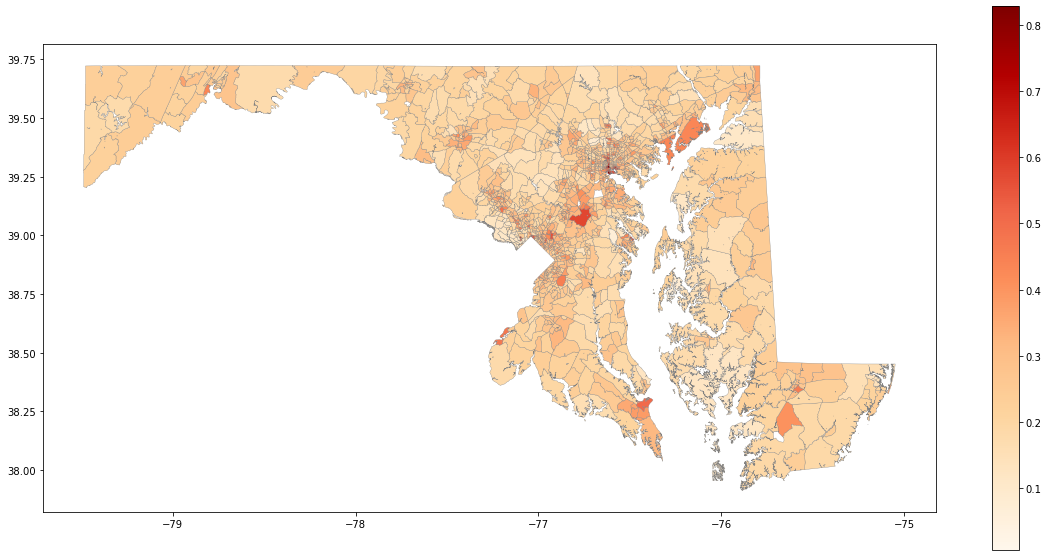

Age40-59


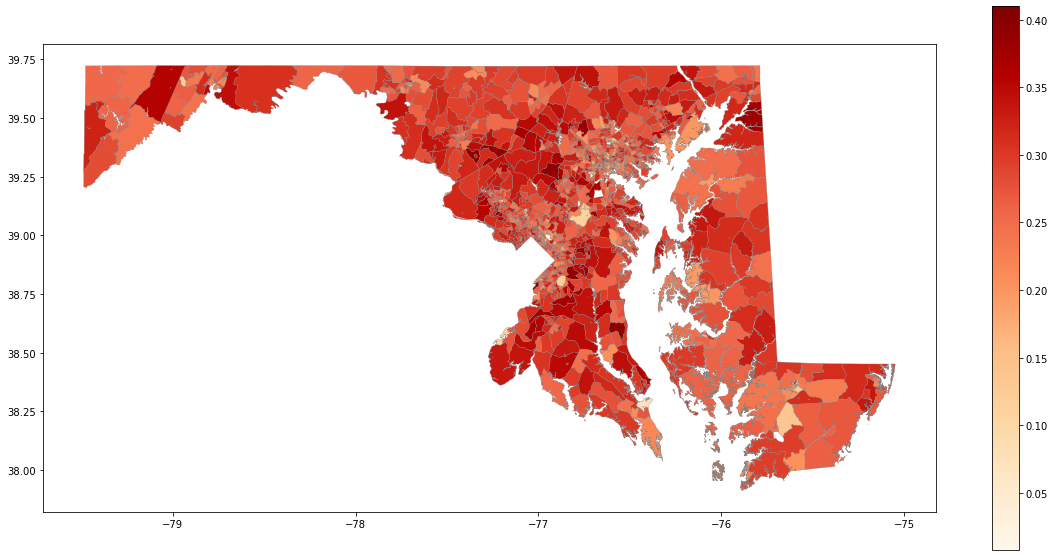

Age60-79


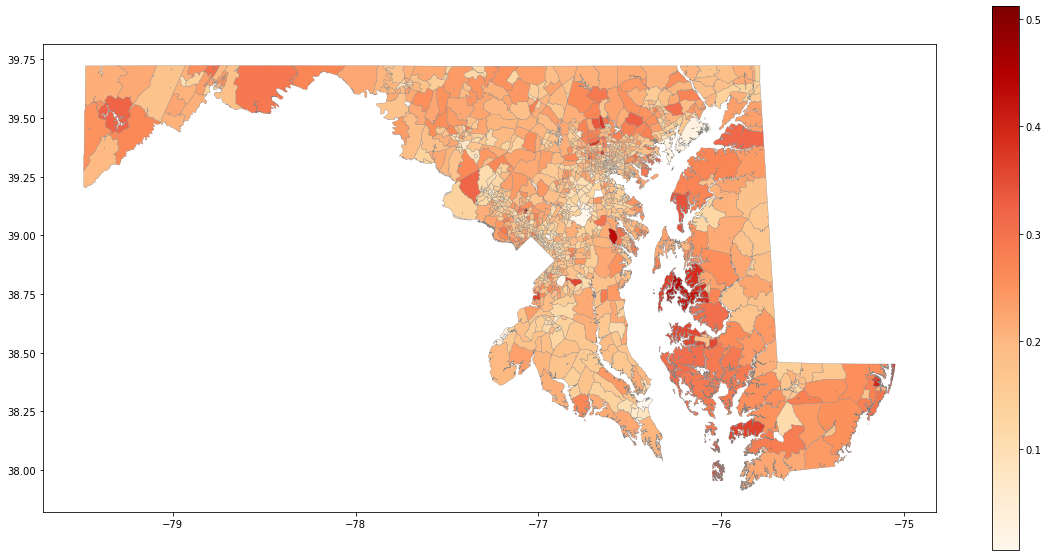

Age80+


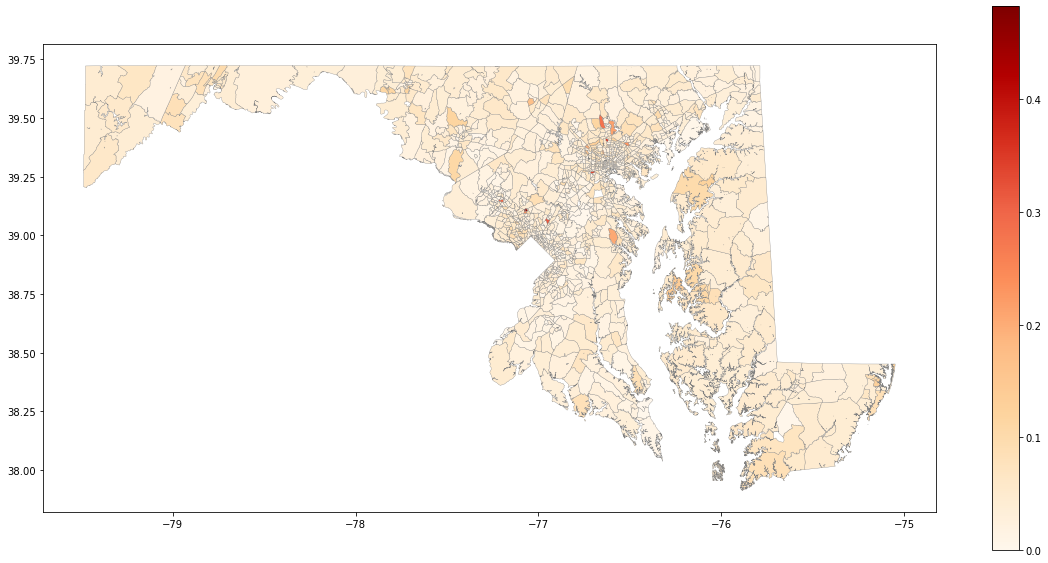

Bachelor+


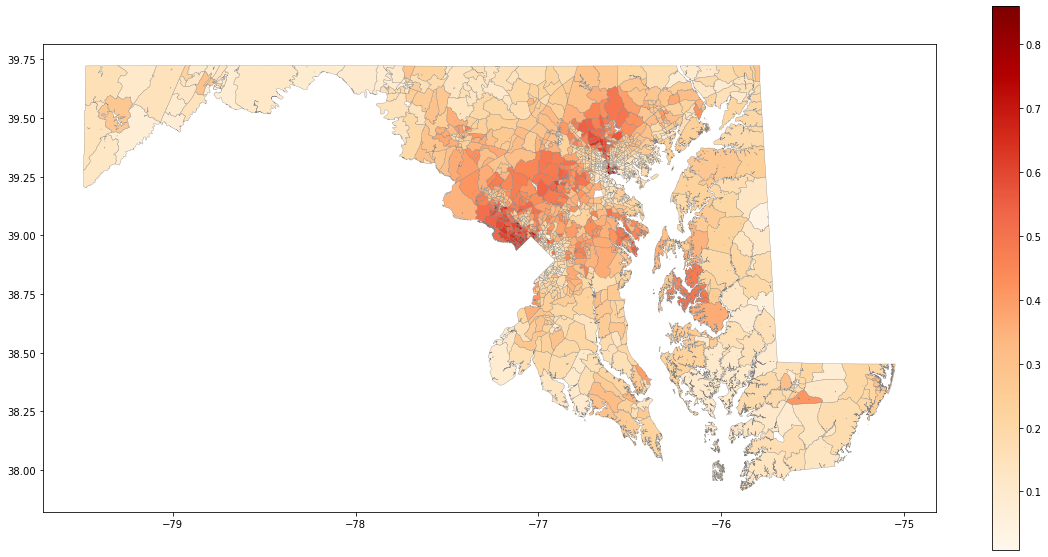

BelowPov


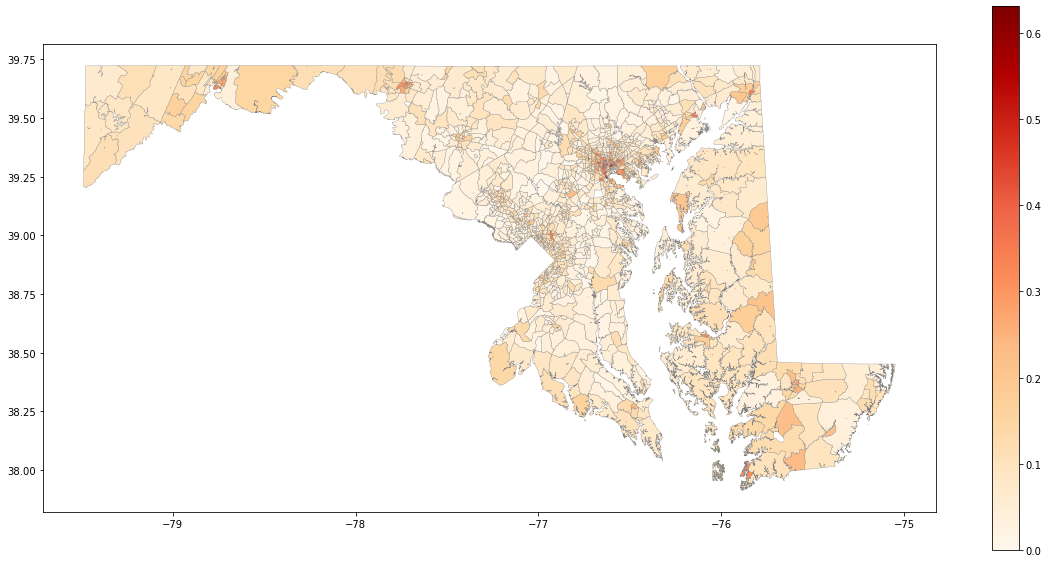

MHI


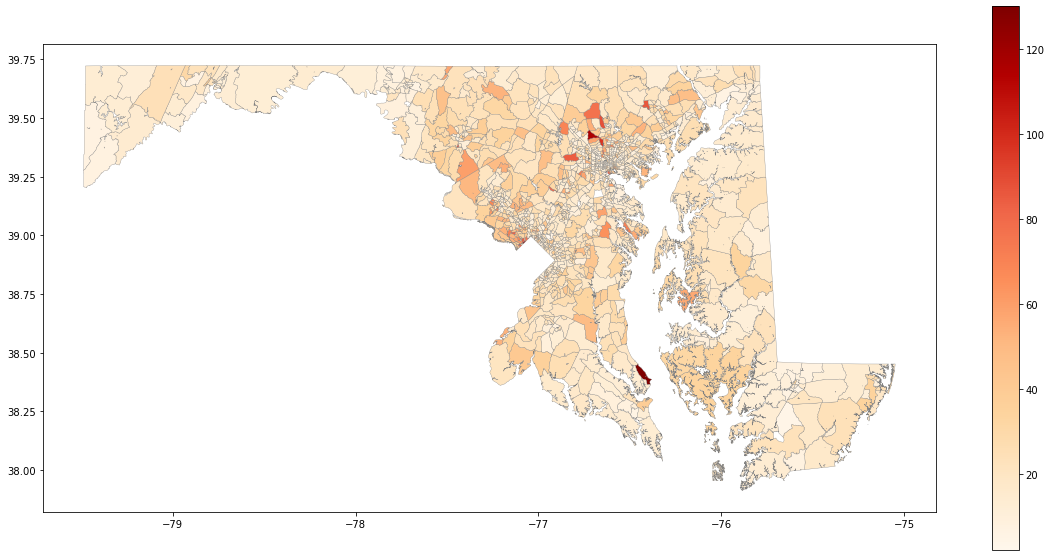

UnempRt


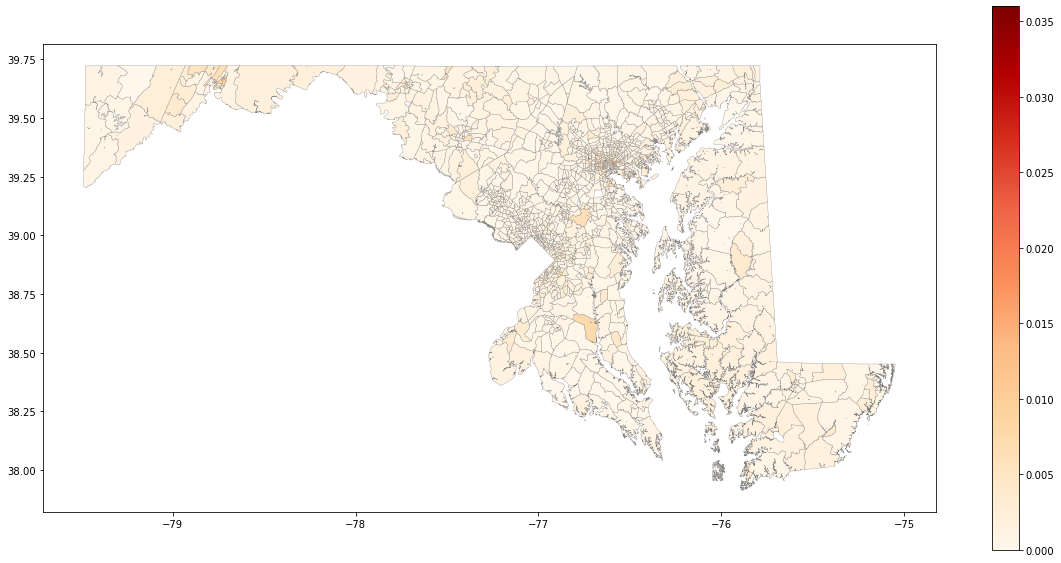

Uninsured


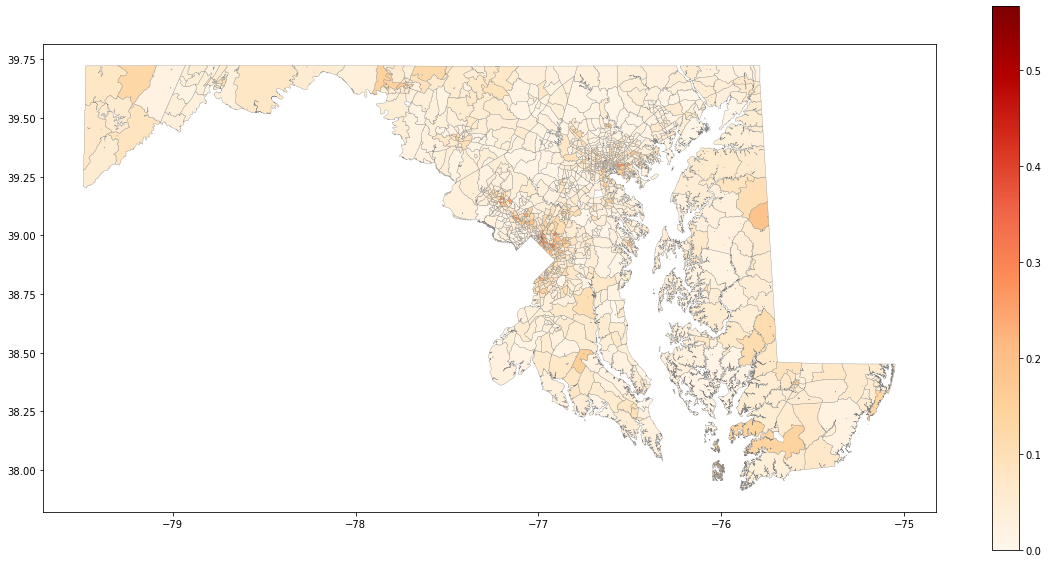

In [68]:
cols = ['White', 'Black', 'Native', 'Asian',
       'Other', 'PopDen', 'Age0-19', 'Age20-39', 'Age40-59', 'Age60-79',
       'Age80+', 'Bachelor+', 'BelowPov', 'MHI', 'UnempRt', 'Uninsured']

for col in cols:
    print(col)
    fig, ax = plt.subplots(figsize=(20, 10))
    df.plot(col,
           cmap="OrRd", edgecolor="grey", linewidth=0.3,
           legend=True, ax=ax)
    plt.show()
    fig.savefig("figs/demographics/%s.png" % col, dpi=220)

### Local Moran's I

In [69]:
w = sw.Queen.from_dataframe(df)

C:\Users\august_zhu\miniconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


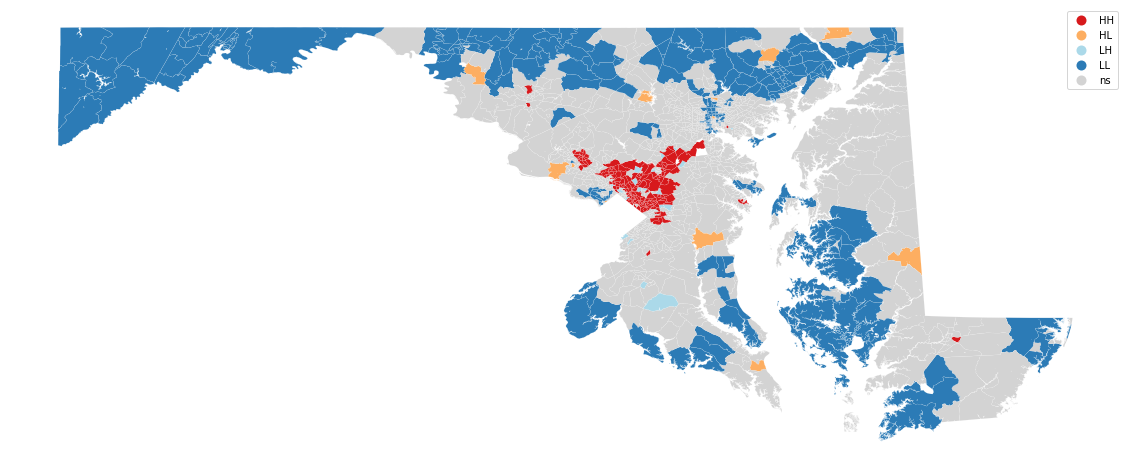

In [73]:
lisa = Moran_Local(df["case0630"], w)
fig, ax = lisa_cluster(lisa, df, figsize=(20, 10))
plt.show()

fig.savefig("figs/COVID-19/hotspot_0630.png", dpi=220)

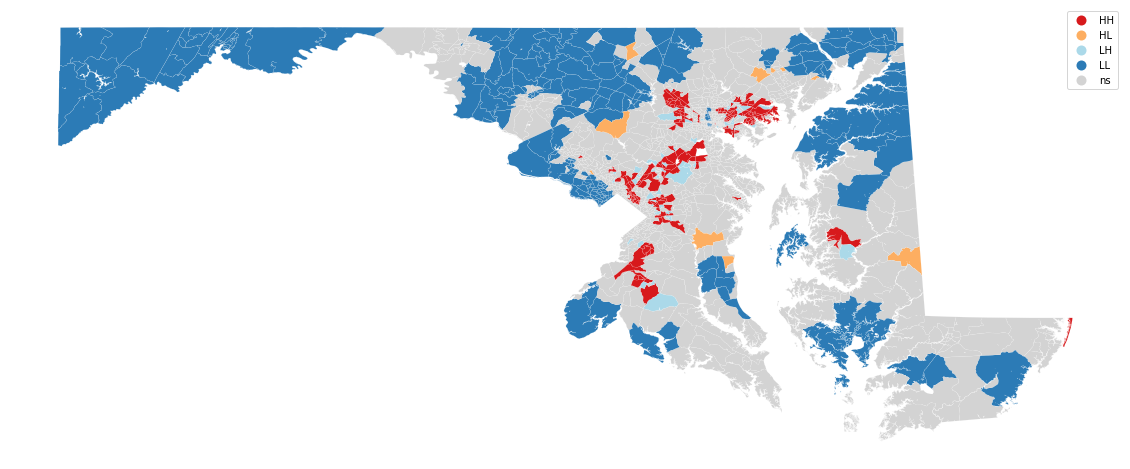

In [74]:
lisa = Moran_Local(df["case0831"], w)
fig, ax = lisa_cluster(lisa, df, figsize=(20, 10))
plt.show()

fig.savefig("figs/COVID-19/hotspot_0831.png", dpi=220)

### Spatial clustering

In [80]:
w = sw.KNN.from_dataframe(df, k=4)

In [100]:
np.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(df[["case0630"]])

AgglomerativeClustering(connectivity=<1384x1384 sparse matrix of type '<class 'numpy.float64'>'
	with 5536 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

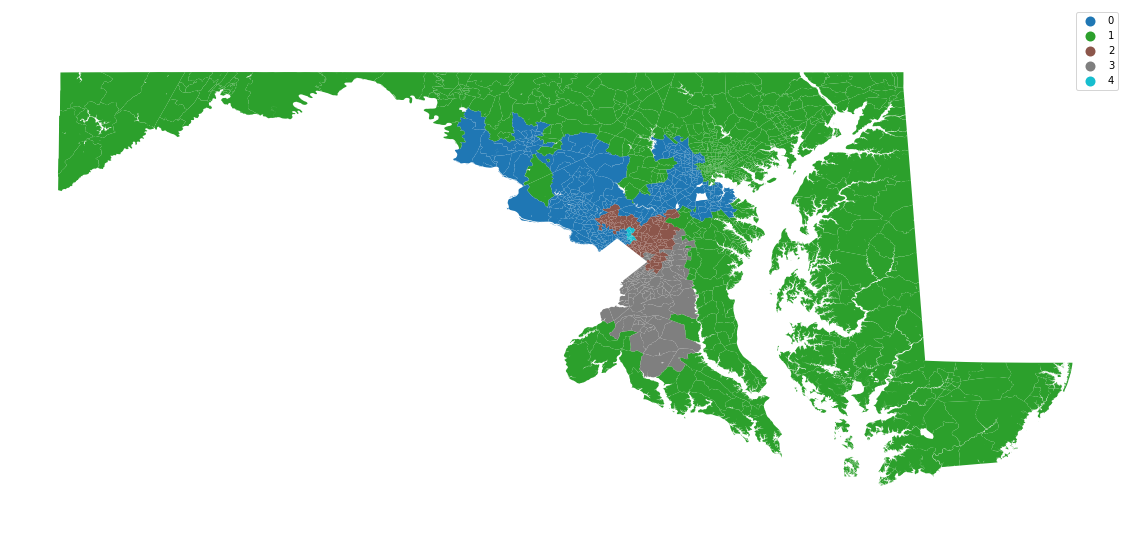

In [108]:
df['region1'] = model.labels_

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(column='region1', categorical=True, legend=True, linewidth=0.3, ax=ax)

ax.set_axis_off()
plt.axis('equal')
# plt.title('Geodemographic Regions (Ward, $k=5$, four nearest neighbors)')

plt.show()
fig.savefig("figs/COVID-19/region_0630.png", dpi=220)

In [102]:
np.random.seed(123456)
model2 = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model2.fit(df[["case0831"]])

AgglomerativeClustering(connectivity=<1384x1384 sparse matrix of type '<class 'numpy.float64'>'
	with 5536 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

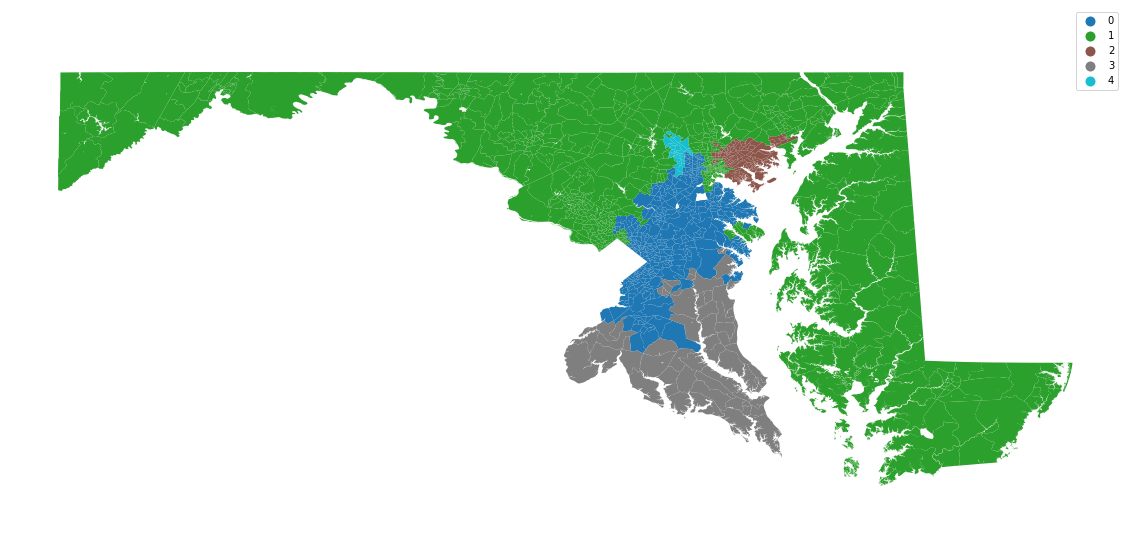

In [109]:
region2 = []
for i in model2.labels_:
    if i == 0:
        region2.append(1)
    elif i == 1:
        region2.append(0)
    else:
        region2.append(i)
df['region2'] = region2

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(column='region2', categorical=True, legend=True, linewidth=0.3, ax=ax)

ax.set_axis_off()
plt.axis('equal')
# plt.title('Geodemographic Regions (Ward, $k=5$, four nearest neighbors)')

plt.show()
fig.savefig("figs/COVID-19/region_0831.png", dpi=220)